In [ ]:
! pip install -U git+https://github.com/huggingface/transformers.git
! pip install -U git+https://github.com/huggingface/accelerate.git
# !pip install medspacy
!pip install sentence-transformers
!pip install clinitokenizer

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-zcgwu4ej
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-zcgwu4ej
  Resolved https://github.com/huggingface/transformers.git to commit 91931882767d2f64073330982ed4a1b8c9aaeee0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.30.0.dev0-py3-none-any.whl size=7137964 sha256=38abf888d8f05ff5d50c509a071cec78f912dc28c97b336a1b623be2c860ad41
  Stored in directory: /tmp/pip-ephem-wheel-cache-gdl2pzoo/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.29.2
    Uninstalling transformers-4.29.2:
      Successfully uninstalled transformers-4.29.2
  Cloning https://github.com

In [ ]:
import numpy as np 
import pandas as pd
import os

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})

In [ ]:
df = pd.read_csv('/kaggle/input/morticd10/codes.csv')

#structuring
df.columns = ['prefix_codes', 'decimal', 'codes', 'description', 'long_description', 'label']

In [ ]:
len(df.prefix_codes.unique()), len(df)

In [ ]:
category_distribution = df['prefix_codes'].value_counts()
lower_threshold = 4
upper_threshold = 12
filtered_categories = category_distribution[(category_distribution > lower_threshold) & (category_distribution < upper_threshold)]

# print(filtered_categories)

In [ ]:
new_df = df[df['prefix_codes'].isin(filtered_categories.index)]

In [63]:
new_df = new_df.sample(frac=1, random_state=23)
print(f"Size: {len(new_df)}")
new_df.head()

Size: 18206


,prefix_codes,decimal,codes,description,long_description,label
71244,Z7712,1,Z77121,Contact w and exposure to harmful algae and al...,Contact with and (suspected) exposure to harmf...,Contact with and (suspected) exposure to hazar...
15939,M80819,A,M80819A,"Oth osteopor w current path fracture, unsp sho...",Other osteoporosis with current pathological f...,Other osteoporosis with current pathological f...
20165,O36833,9,O368339,Matern care for abnlt of fetl hrt rate or rhym...,Maternal care for abnormalities of the fetal h...,Maternal care for abnormalities of the fetal h...
741,B35,6,B356,Tinea cruris,Tinea cruris,Dermatophytosis
8435,I05,9,I059,"Rheumatic mitral valve disease, unspecified","Rheumatic mitral valve disease, unspecified",Rheumatic mitral valve diseases


In [64]:
len(new_df.prefix_codes.unique())

2752

In [65]:
def normalise_text (text):
    text = text.lower() # lowercase
    text = text.replace(r"\#","") # replaces hashtags
    text = text.replace(r"@","")
    text = text.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.replace("\s{2,}", " ")
    return text

new_df['long_description'] = new_df['long_description'].apply(normalise_text)
new_df.head()

,prefix_codes,decimal,codes,description,long_description,label
71244,Z7712,1,Z77121,Contact w and exposure to harmful algae and al...,contact with and (suspected) exposure to harmf...,Contact with and (suspected) exposure to hazar...
15939,M80819,A,M80819A,"Oth osteopor w current path fracture, unsp sho...",other osteoporosis with current pathological f...,Other osteoporosis with current pathological f...
20165,O36833,9,O368339,Matern care for abnlt of fetl hrt rate or rhym...,maternal care for abnormalities of the fetal h...,Maternal care for abnormalities of the fetal h...
741,B35,6,B356,Tinea cruris,tinea cruris,Dermatophytosis
8435,I05,9,I059,"Rheumatic mitral valve disease, unspecified","rheumatic mitral valve disease, unspecified",Rheumatic mitral valve diseases


In [288]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

labels = new_df.prefix_codes.unique()

model = SentenceTransformer('all-MiniLM-L6-v2')
label_embeddings = model.encode(labels)

kmeans = KMeans(n_clusters=8, random_state=23).fit(label_embeddings)
label_to_cluster = {label: cluster for label, cluster in zip(labels, kmeans.labels_)}

new_df['new_codes'] = new_df['prefix_codes'].map(label_to_cluster)

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


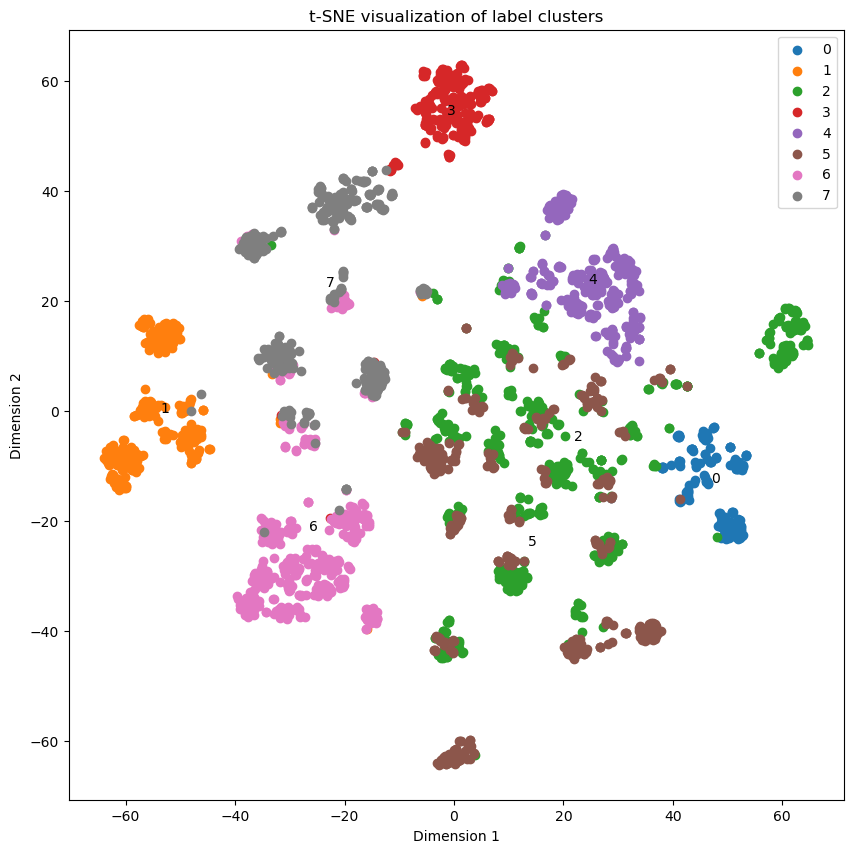

In [289]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Use t-SNE to reduce the label embeddings to 2 dimensions
tsne_model = TSNE(n_components=2, random_state=23)
label_embeddings_2d = tsne_model.fit_transform(label_embeddings)

# Create a scatter plot of the 2D embeddings, with each cluster a different color
plt.figure(figsize=(10, 10))

for cluster in np.unique(kmeans.labels_):
    indices = np.where(kmeans.labels_ == cluster)
    cluster_points = label_embeddings_2d[indices]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=cluster)
    
    # Compute the centroid of the cluster and annotate the plot with the cluster number
    centroid = np.mean(cluster_points, axis=0)
    plt.annotate(str(cluster), (centroid[0], centroid[1]))

plt.title('t-SNE visualization of label clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()


In [290]:
print(f'Dataset Size: {len(new_df)}')
new_df.head()

Dataset Size: 18206


,prefix_codes,decimal,codes,description,long_description,label,new_codes
71244,Z7712,1,Z77121,Contact w and exposure to harmful algae and al...,contact with and (suspected) exposure to harmf...,Contact with and (suspected) exposure to hazar...,5
15939,M80819,A,M80819A,"Oth osteopor w current path fracture, unsp sho...",other osteoporosis with current pathological f...,Other osteoporosis with current pathological f...,4
20165,O36833,9,O368339,Matern care for abnlt of fetl hrt rate or rhym...,maternal care for abnormalities of the fetal h...,Maternal care for abnormalities of the fetal h...,0
741,B35,6,B356,Tinea cruris,tinea cruris,Dermatophytosis,2
8435,I05,9,I059,"Rheumatic mitral valve disease, unspecified","rheumatic mitral valve disease, unspecified",Rheumatic mitral valve diseases,5


In [291]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = new_df[['long_description']]
y = new_df['new_codes']


encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Split the dataset into a train and temporary set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# Split the temporary set into validation and train set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=23)

print(X_train.shape, X_val.shape, X_test.shape)

(10923, 1) (3641, 1) (3642, 1)


In [292]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchtext

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, Trainer, TrainingArguments


##Clinical BERT
# tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
# model = AutoModelForSequenceClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', 
#                                                            num_labels=len(new_df['new_codes'].unique()))

# best_model = AutoModelForSequenceClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', 
#                                                            num_labels=len(new_df['new_codes'].unique()))

##ICD-10-Code-Prediction"
# from transformers import AutoTokenizer, BertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("AkshatSurolia/ICD-10-Code-Prediction")
model = BertForSequenceClassification.from_pretrained("AkshatSurolia/ICD-10-Code-Prediction", 
                                                      num_labels=len(new_df['new_codes'].unique()),
                                                     ignore_mismatched_sizes=True)

best_model = BertForSequenceClassification.from_pretrained("AkshatSurolia/ICD-10-Code-Prediction",
                                                          num_labels=len(new_df['new_codes'].unique()),
                                                          ignore_mismatched_sizes=True)

##DistilBert
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertConfig

# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# model = DistilBertForSequenceClassification.from_pretrained(
#     'distilbert-base-uncased', # Use the 12-layer BERT model, with an uncased vocab.
#     num_labels = len(new_df['new_codes'].unique()))

# best_model = DistilBertForSequenceClassification.from_pretrained(
#     'distilbert-base-uncased', # Use the 12-layer BERT model, with an uncased vocab.
#     num_labels = len(new_df['new_codes'].unique()))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at AkshatSurolia/ICD-10-Code-Prediction and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([15931, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([15931]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at AkshatSurolia/ICD-10-Code-Prediction and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([15931, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([15931]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably

In [293]:
print(f"Input Ids: {tokenizer(X_train.iloc[100].long_description, truncation=True, padding=True)['input_ids']}")
print(f"Attention Masks: {tokenizer(X_train.iloc[100].long_description, truncation=True, padding=True)['attention_mask']}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Input Ids: [101, 13577, 23455, 22869, 1104, 9202, 1104, 21820, 27955, 117, 1286, 1981, 117, 4194, 8107, 1111, 22869, 1114, 1664, 19698, 102]
Attention Masks: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [294]:
class CustomDataset(Dataset):
    def __init__(self, X, y, tokenizer, max_length):
        self.data = []
        for i in zip(X, y):
            text, target = i[0], i[1]
            self.data.append((text, int(target)))
            self.tokenizer = tokenizer
            self.max_length = max_length
            

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, target = self.data[idx]
        inputs = self.tokenizer(text, padding='max_length', truncation=True, 
                                max_length=self.max_length, return_tensors='pt')
        inputs_ids = inputs['input_ids'].squeeze(0)
        attention_masks = inputs['attention_mask'].squeeze(0)
        return inputs_ids, attention_masks, target 

In [295]:
sentences = new_df["long_description"]
sentences_tokenized = [tokenizer.tokenize(sentence) for sentence in sentences ]

print('Max sentence length: ', max([len(sen) for sen in sentences_tokenized]))
max_len = max([len(sen) for sen in sentences_tokenized])

Max sentence length:  41


In [296]:
train_dataset = CustomDataset(X_train, y_train, tokenizer, max_len)
val_dataset = CustomDataset(X_val, y_val, tokenizer, max_len)

batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


In [297]:
next(iter(train_dataset))

(tensor([ 101, 1263,  168, 6136,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0]),
 tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 7)

In [298]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [299]:
model = model.to(device)

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (28996, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [300]:
optimizer = AdamW (model.parameters(),
                  lr =4e-5, 
                  eps = 1e-8, 
                  weight_decay=0.05
                )
loss_fn = torch.nn.CrossEntropyLoss()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [301]:
import numpy as np
from torch.nn import functional as F

def compute_acc(preds, labels):
    correct = 0
    preds_ = preds.data.max(1)[1]
    correct = preds_.eq(labels.data).cpu().sum()
    acc = float(correct) / float(len(labels.data)) * 100.0
    return acc

In [302]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [303]:
def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(val_losses, label='Validation Loss')
    axs[0].set_title("Losses over Epochs")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    
    axs[1].plot(train_accuracies, label='Train Accuracy')
    axs[1].plot(val_accuracies, label='Validation Accuracy')
    axs[1].set_title("Accuracies over Epochs")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    
    plt.tight_layout()

In [304]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 50
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [305]:
from IPython.display import clear_output

patience = 10
num_no_improvement = 0 

# Store the average loss after each epoch so we can plot them.
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
show_every = 500

# Keep track of the best validation loss
best_val_loss = float('inf')


# For each epoch...
for epoch_i in range(0, epochs):
    store_train_loss = []
    store_train_acc = []
    store_val_loss = []
    store_val_acc = []
    
     # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0
    
    model.train()
    
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        inputs_ids, attention_masks, labels = batch
        model.zero_grad()

        outputs = model(inputs_ids, attention_mask=attention_masks)
        
        loss = F.cross_entropy(outputs[0], labels)
        train_acc = compute_acc(outputs[0], labels)

        # Print the statistics
        store_train_loss.append(loss.item())
        store_train_acc.append(train_acc)
        
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()

        # Update the learning rate.
        scheduler.step()
        
        # Progress update every 40 batches.
        if step % show_every == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {} / {}.  Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            print('Training loss: %.3f  Training acc: %.3f'%(np.mean(store_train_loss[-show_every:]), np.mean(store_train_acc[-show_every:])) ) 
#             clear_output(wait=True)
    
        
    # compute epoch loss and accuracy 
    train_losses.append(np.mean(store_train_loss))
    train_accuracies.append(np.mean(store_train_acc))
    
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
    
    
    
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    
    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    
    # Evaluate data for one epoch
    for batch in val_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        val_inputs_ids, val_attention_masks, val_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():  
            val_outputs = model(val_inputs_ids,  
                            attention_mask=val_attention_masks)
            
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        val_logits = val_outputs[0]
        
        val_loss = F.cross_entropy(val_logits, val_labels)
        
        # Calculate the accuracy for this batch of test sentences.
        val_acc = compute_acc(val_logits, val_labels)
        
        store_val_loss.append(val_loss.item())
        store_val_acc.append(val_acc)
        
    
    # compute epoch loss and accuracy 
    mean_val_loss = np.mean(store_val_loss)
    val_losses.append(mean_val_loss)
    val_accuracies.append(np.mean(store_val_acc))
        
    # Report the final accuracy for this validation run.
    # Print loss and acc at the end of the epoch
    print("Epoch {}: Train Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%".format
    (epoch_i, train_losses[-1], val_losses[-1], train_accuracies[-1], val_accuracies[-1]))
    


    #Check if validation loss has improved
    if np.mean(mean_val_loss < best_val_loss):
        best_val_loss = mean_val_loss
        # Get the current state of the model
        model_state_dict = model.state_dict()
        best_model.load_state_dict(model_state_dict)
        num_no_improvement = 0 
    else:
        num_no_improvement+=1 
    if num_no_improvement == patience: 
        break

print("")
print("Training complete!")


======== Epoch 1 / 50 ========
Training...
  Training epoch took: 0:00:01

Running Validation...
Epoch 0: Train Loss: 2.1815, Validation Loss: 1.7945, Train Accuracy: 0.00%, Validation Accuracy: 0.00%

======== Epoch 2 / 50 ========
Training...
  Training epoch took: 0:00:01

Running Validation...
Epoch 1: Train Loss: 0.9548, Validation Loss: 2.7129, Train Accuracy: 100.00%, Validation Accuracy: 0.00%

======== Epoch 3 / 50 ========
Training...
  Training epoch took: 0:00:01

Running Validation...
Epoch 2: Train Loss: 0.6282, Validation Loss: 3.2414, Train Accuracy: 100.00%, Validation Accuracy: 0.00%

======== Epoch 4 / 50 ========
Training...
  Training epoch took: 0:00:01

Running Validation...
Epoch 3: Train Loss: 0.3532, Validation Loss: 3.5142, Train Accuracy: 100.00%, Validation Accuracy: 0.00%

======== Epoch 5 / 50 ========
Training...
  Training epoch took: 0:00:01

Running Validation...
Epoch 4: Train Loss: 0.2676, Validation Loss: 3.4665, Train Accuracy: 100.00%, Validatio

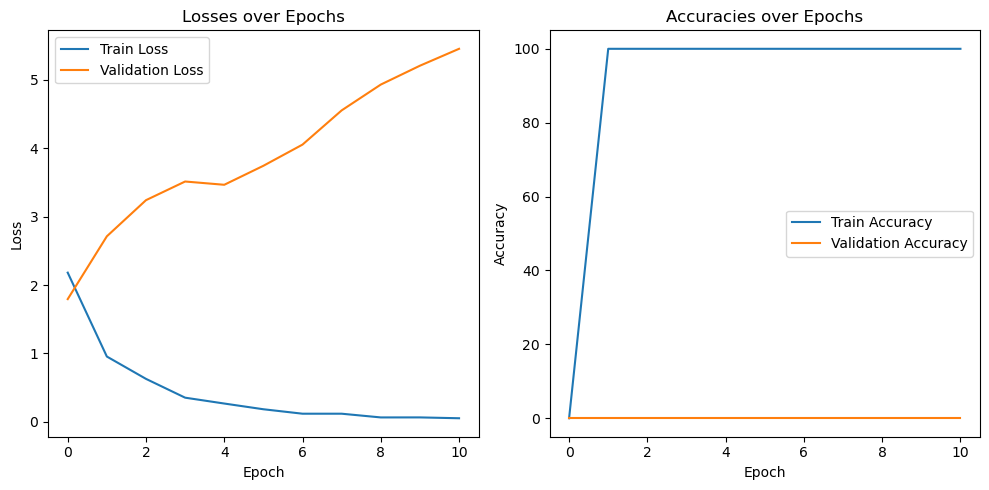

In [306]:
import matplotlib.pyplot as plt
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)

In [307]:
X_test.iloc[0].long_description

'salter-harris type iv physeal fracture of lower end of humerus, right arm, subsequent encounter for fracture with malunion'

In [308]:
import numpy as np


model.eval()
model.eval()
with torch.no_grad():
    # Visualize the attention weights for a sample input
    text = X_test.iloc[0].long_description
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    outputs = model(**inputs.to(device), output_attentions=True)
    predictions = torch.max(outputs[0], dim=1)[1]
    
print(predictions)

tensor([2])


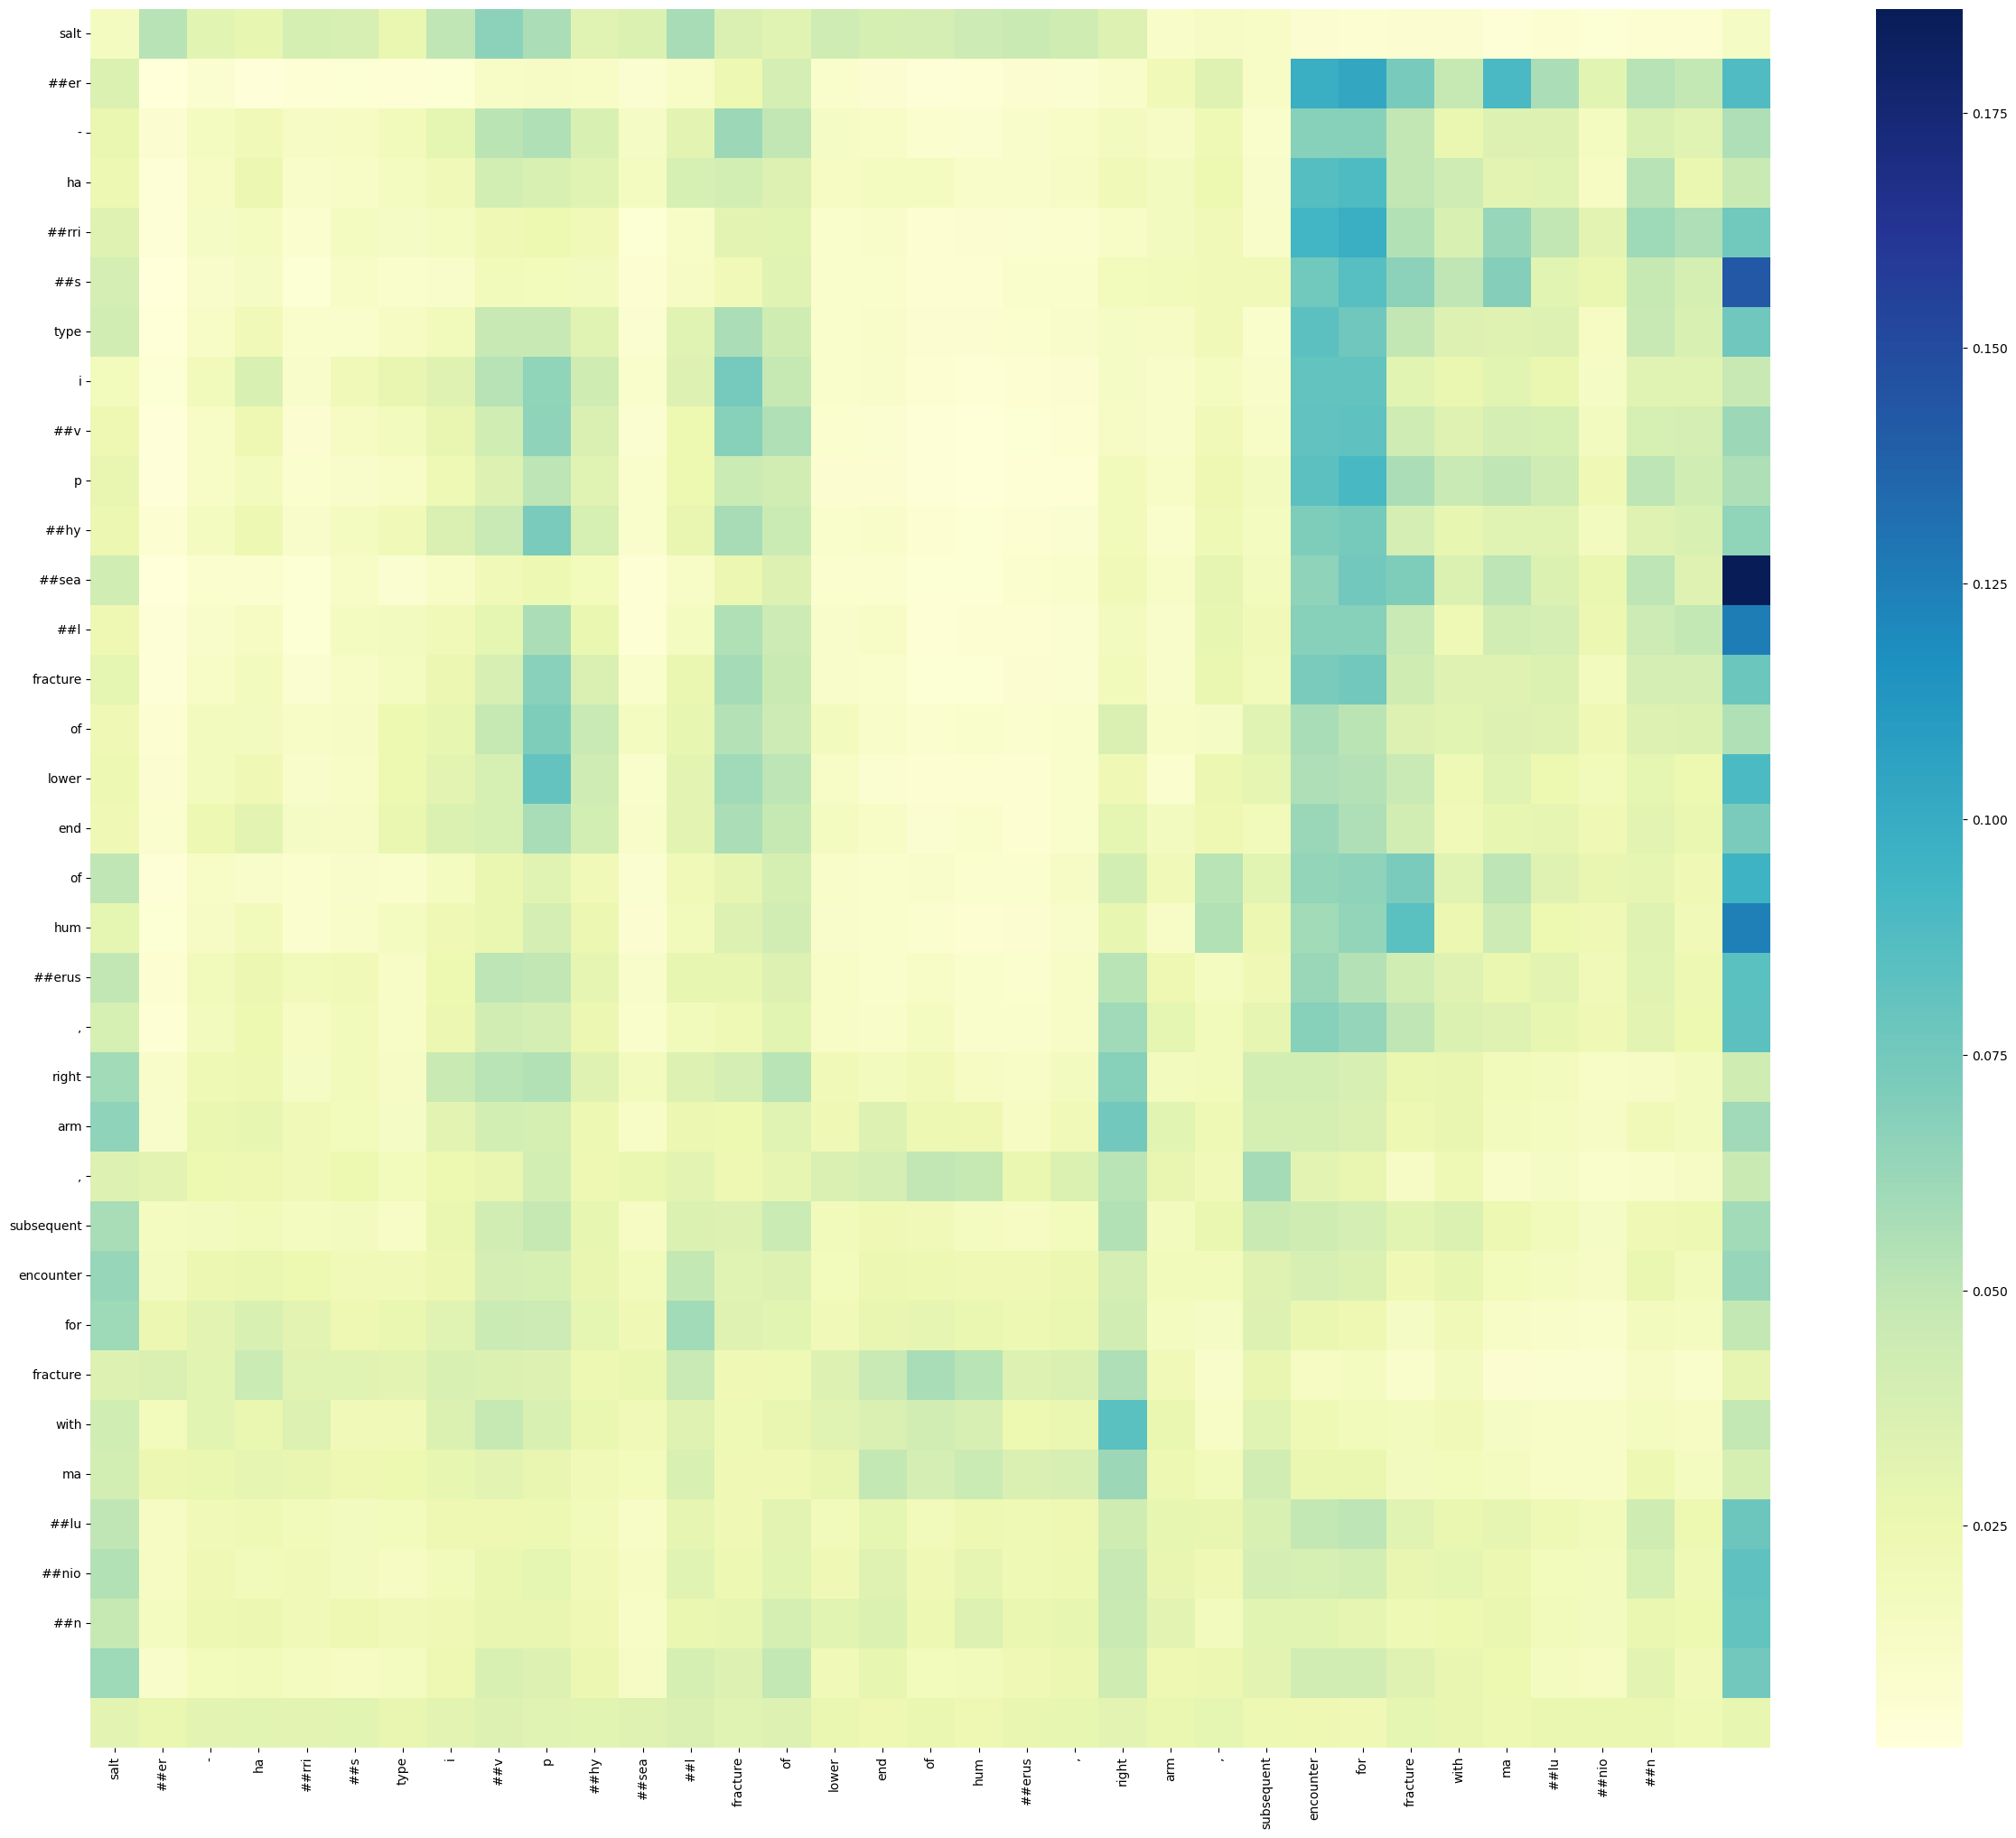

In [309]:
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the testing set
import numpy as np

model.eval()
model.eval()
with torch.no_grad():
    # Visualize the attention weights for a sample input
    text = X_test.iloc[0].long_description
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    outputs = model(**inputs.to(device), output_attentions=True)
    attention_weights = outputs.attentions[-1][0][0]
    attention_weights = attention_weights.cpu()
    plt.figure(figsize=(30, 25))
    sns.heatmap(attention_weights, cmap="YlGnBu", xticklabels=tokenizer.tokenize(text), yticklabels=tokenizer.tokenize(text), annot=False)
    plt.show()

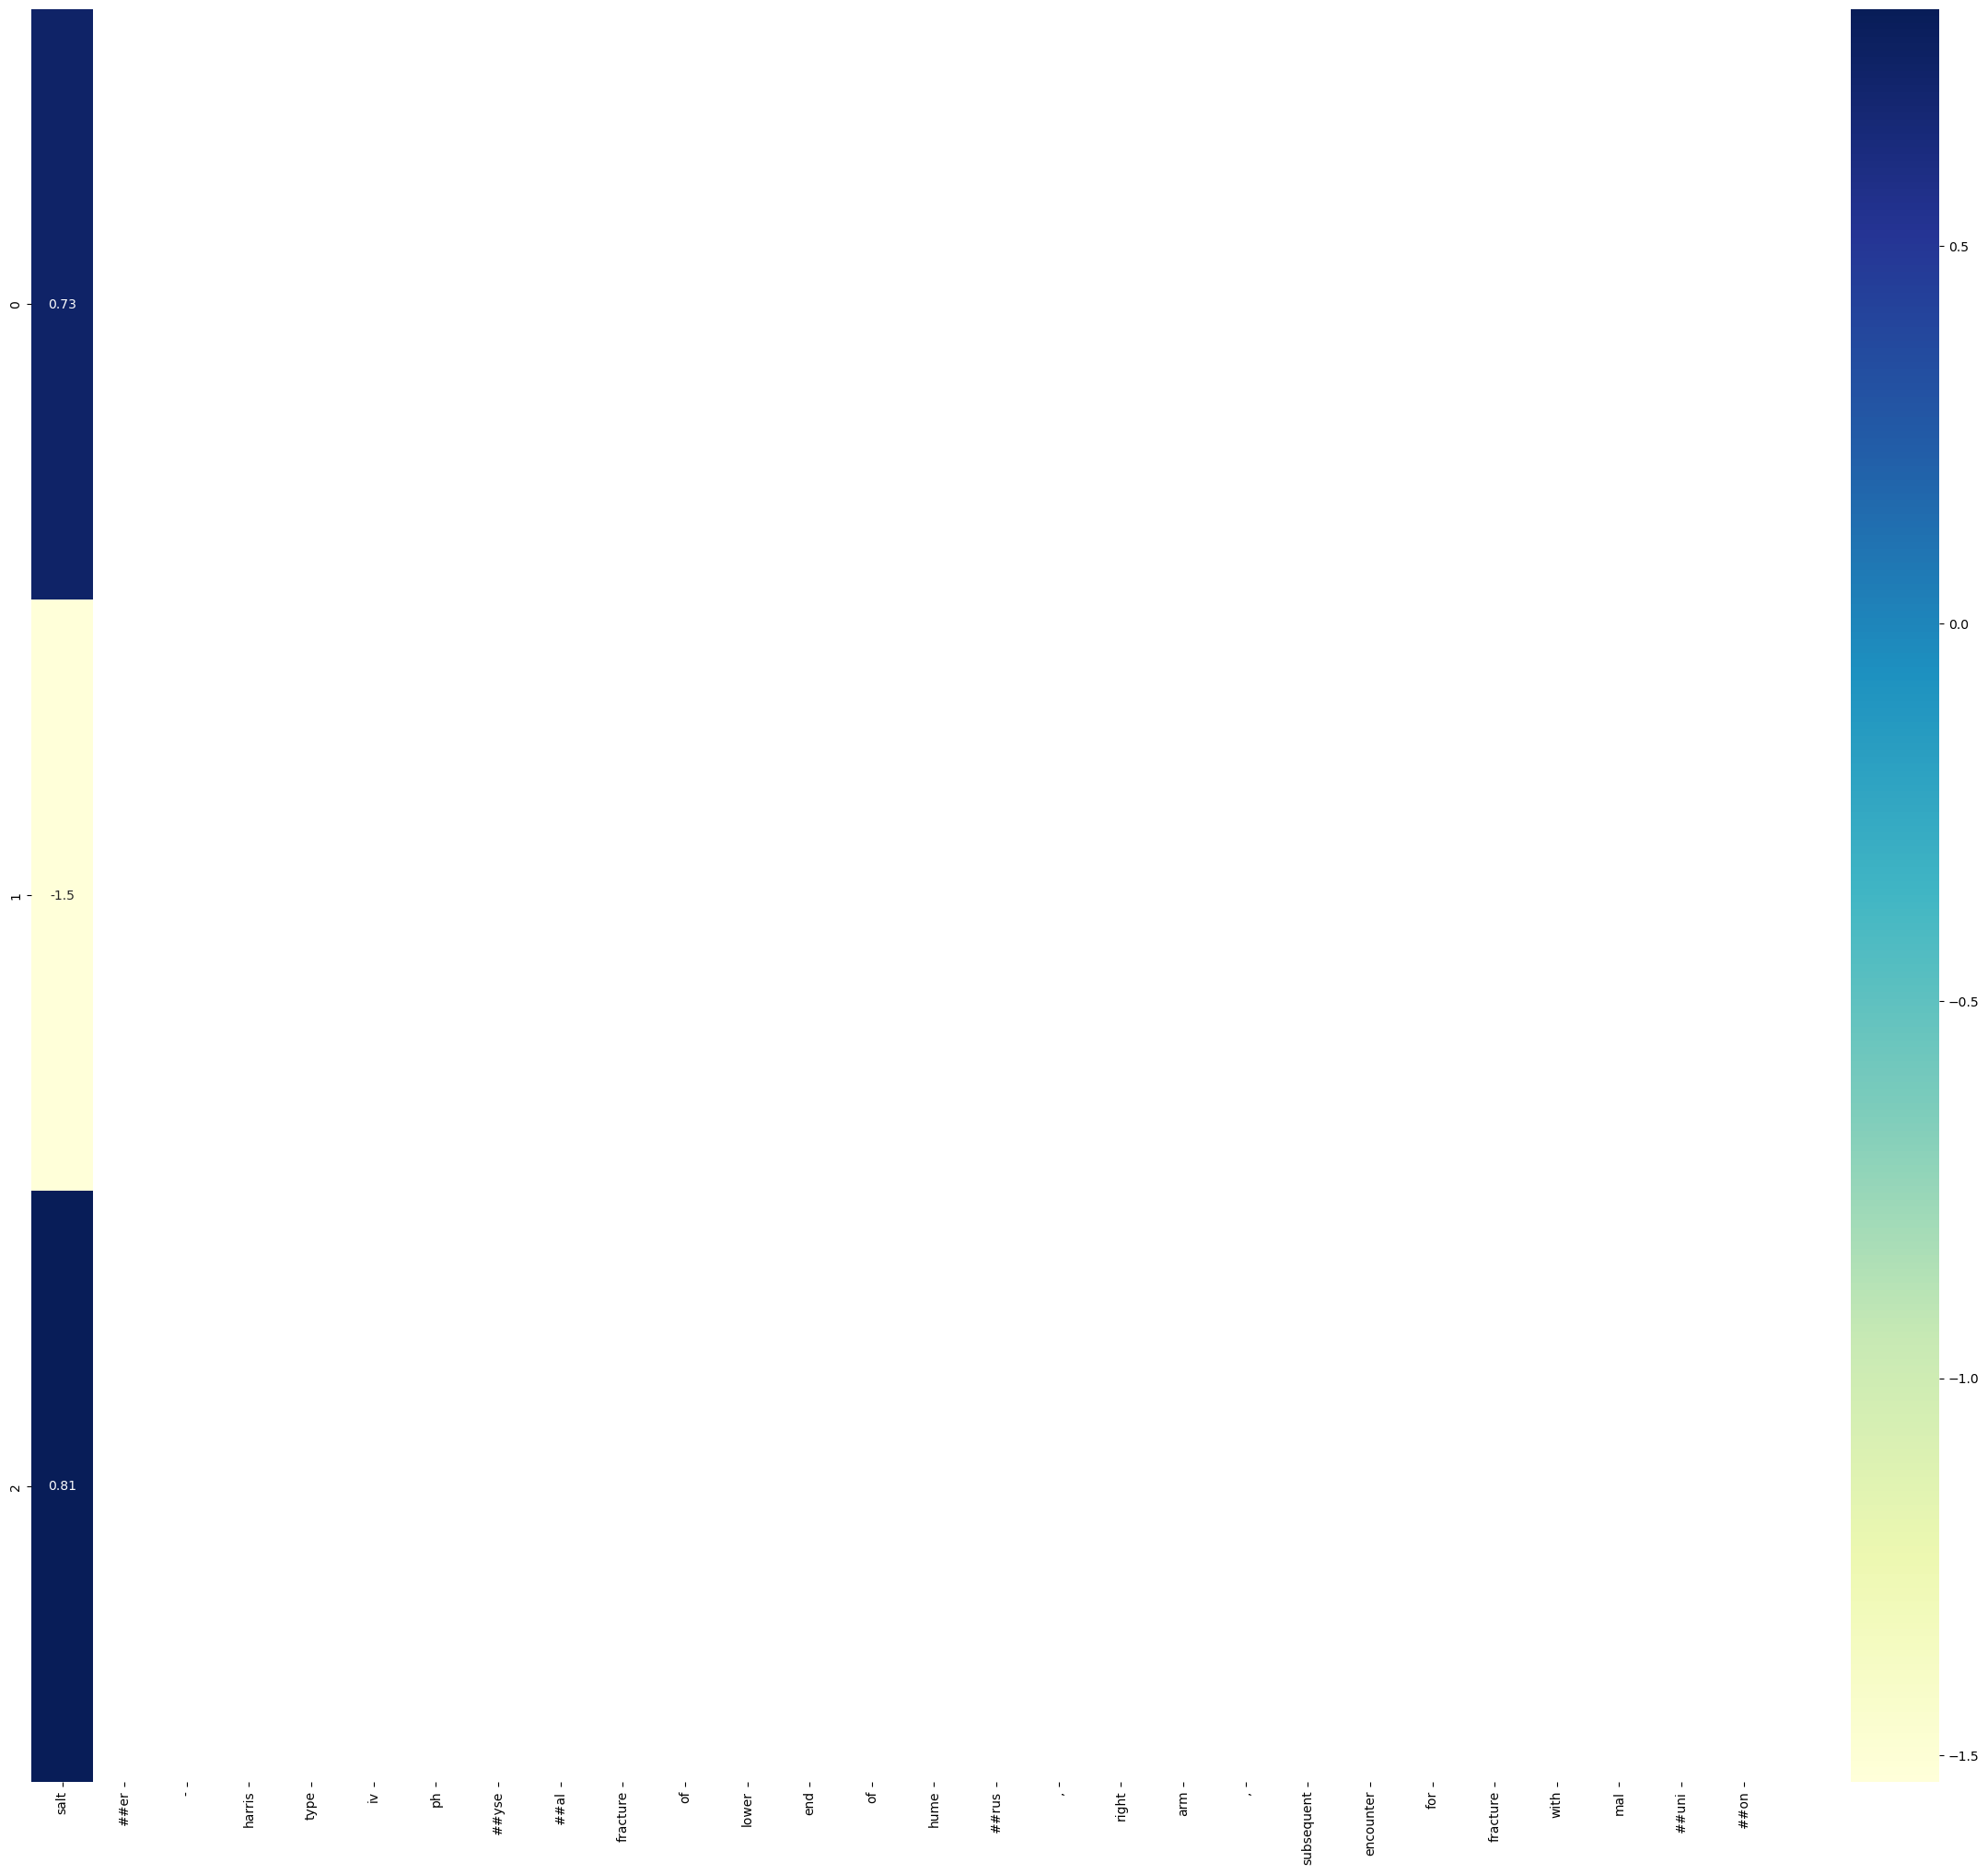

In [250]:
with torch.no_grad():
    inputs_test = tokenizer(list(X_test[:3].long_description), padding=True, truncation=True, return_tensors='pt')
    labels_test = torch.tensor(list(y_test[:3]))
    baseline_score = loss_fn(model(**inputs_test.to(device), labels=labels_test.to(device)).logits, labels_test.to(device))
    feature_importance = []
    for i, feature in enumerate(inputs_test['input_ids']):
        scores = []
        for j in range(feature.shape[0]):
            # Permute the feature along the sequence dimension
            permuted_feature = feature.clone()
            permuted_feature[j] = torch.randint(tokenizer.vocab_size, size=(1,))
#             # Encode the permuted feature
            inputs_permuted = {key: val[i:i+1] for key, val in inputs_test.items()}
            inputs_permuted['input_ids'] = permuted_feature
            inputs_permuted['input_ids'] = inputs_permuted['input_ids'].unsqueeze(0)
            inputs_permuted['attention_mask'] = inputs_permuted['attention_mask'].unsqueeze(0)
            
            # Calculate the score for the permuted feature
            O = model(**inputs_permuted).logits
            score = loss_fn(O, labels_test[i:i+1].to(device))
            scores.append(score)
        # Calculate the feature importance as the difference from the baseline score
        feature_importance.append(baseline_score - torch.mean(torch.stack(scores)))
        feature_imp = torch.stack(feature_importance)
    # Visualize the feature importance as a heatmap
    plt.figure(figsize=(30, 25))
    sns.heatmap(feature_imp.cpu().unsqueeze(1).numpy(), cmap="YlGnBu", xticklabels=tokenizer.tokenize(text), annot=True)
    plt.show()